Bias correction based on the [python Package scikit-downscale](https://github.com/pangeo-data/scikit-downscale/blob/main/examples/2020ECAHM-scikit-downscale.ipynb)

Here, only the pointwise method to apply

First, comparison of observation and modelled data's behaviour
        Comparison of the distribution of data with boxplots
        Evolution through time with graphs

Second, BC at each meteorological station

# User input

In [1]:
# climate variable wanted
# observation data wanted

# modeled data wanted
# station of observation wanted 

climate_var = 'pr' # 'tas'

# precipitation : 'pr'

name_station = 'BEIRA, MZ'

# Packages and functions

## Packages

In [2]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import os
import os.path
from datetime import datetime

## Functions

### Data treatment

#### NOAA

In [3]:
# this function is meant to import the NOAA observation data
def import_treat_obs_NOAA():
    # path where the file is placed
    path_file_NOAA = r'C:\Users\CLMRX\COWI\A248363 - Climate analysis - Documents\General\CRVA_tool\Master_thesis\Project\3 - Implementation\1 - Data\1-BC\NOAA-ClimateDataOnline\3370204.csv'
    # read the information in the file
    data_obs_NOAA = pd.read_csv(path_file_NOAA)
    # unit of PRCP are mm
    # unit of temperature are degrees Celsius
    
    # add Year, month and season columns for graphs
    Year = data_obs_NOAA[['DATE']].values.reshape(len(data_obs_NOAA[['DATE']].values),)
    Month = data_obs_NOAA[['DATE']].values.reshape(len(data_obs_NOAA[['DATE']].values),)
    Season = data_obs_NOAA[['DATE']].values.reshape(len(data_obs_NOAA[['DATE']].values),)
    for i in np.arange(0,len(data_obs_NOAA[['DATE']].values)):
        Year[i]=int(Year[i][0:4])
        Month[i]=int(Month[i][5:7])
        if int(Month[i])>3 and int(Month[i])<10: # dry season in Mozambique is between April and September
            Season[i]='Dry'
        else:# humid season is between October and March
            Season[i]='Humid'

    data_obs_NOAA['Year'] = Year
    data_obs_NOAA['Month'] = Month
    data_obs_NOAA['Season'] = Season
    return data_obs_NOAA

In [4]:
# this function is meant to find which meteo stations are the closest to the projects of interest
# find which stations are of interest, which one are the closest to the coordinates of the projects
def find_closest_meteo_station_to_projects(data_obs_NOAA,name_projects):
    # save in a dataframe name, latitudes and longitudes informations for each station
    df_station_NOAA=data_obs_NOAA.loc[:, ["NAME", "LATITUDE","LONGITUDE"]]
    df_station_NOAA.drop_duplicates(inplace = True) # drop duplicates to only have name of the towns and latitudes and longitudes
    df_station_NOAA.reset_index(drop=True,inplace = True)  # drop = true avoids to keep the former index
    # inplace = True modifies the original dataframe
    
    name_closest_station_to_project = [] # create an empty list to contain the name of the closest station to each project
    index_closest_station_to_project = []
    for (i,name_project) in zip(np.arange(0,len(name_projects)),name_projects):
        # calculate difference between the different coordinates
        df_station_NOAA['Diff latitude project '+str(i)] = abs(abs(df_station_NOAA['LATITUDE']) - abs(lat_projects[i]))
        df_station_NOAA['Diff longitude project '+str(i)] = abs(abs(df_station_NOAA['LONGITUDE']) - abs(lon_projects[i]))
        df_station_NOAA['Diff coordinates project '+str(i)] = df_station_NOAA['Diff latitude project '+str(i)]+df_station_NOAA['Diff longitude project '+str(i)]
        # register the name of the stations that are the closest to the projects and the index in df_station_NOAA corresponding to those closest stations
        name_closest_station = df_station_NOAA['NAME'].iloc[np.where(df_station_NOAA['Diff coordinates project '+str(i)]==min(df_station_NOAA['Diff coordinates project '+str(i)]))[0][0]]
        name_closest_station_to_project.append(name_closest_station)
        index_closest_station_to_project.append(np.where(df_station_NOAA['Diff coordinates project '+str(i)]==min(df_station_NOAA['Diff coordinates project '+str(i)]))[0][0])
        print('The closest meteorological station to the project '+name_project+' is the one located in '+name_closest_station)


    # take off the duplicates from the list of name of station which are the closest to our projects and the indexes in the dataframe of those corresponding stations
    name_closest_station_to_project_without_duplicates=list(set(name_closest_station_to_project))
    index_closest_station_to_project_without_duplicates=list(set(index_closest_station_to_project))
    print('\n')
    print('The coordinates for the meteorological stations which are the closest to the project of interest are :')
    print('\n')
    for k in np.arange(len(index_closest_station_to_project_without_duplicates)):
        print('Name '+df_station_NOAA['NAME'][index_closest_station_to_project_without_duplicates[k]])
        print('Longitude '+str(df_station_NOAA['LONGITUDE'][index_closest_station_to_project_without_duplicates[k]]))
        print('Latitude '+str(df_station_NOAA['LATITUDE'][index_closest_station_to_project_without_duplicates[k]]))
        print('\n')

#### Gorongosa observation precipitation file

In [5]:
# this function is used to import and format data from Gorongosa in a certain format
def import_treat_observed_Gorongosa():
    
    if not os.path.isfile(r'C:\Users\CLMRX\COWI\A248363 - Climate analysis - Documents\General\CRVA_tool\Master_thesis\Project\3 - Implementation\1 - Data\1-BC\DirecltyfromMoz\Precipitation_Gorongosa_reformat.csv'):
        path_file_SIPA = r'C:\Users\CLMRX\COWI\A248363 - Climate analysis - Documents\General\CRVA_tool\Master_thesis\Project\3 - Implementation\1 - Data\1-BC\DirecltyfromMoz\Dados_e_grafico_P_812.xls'
        obs_SIPA=pd.read_excel(path_file_SIPA)
        obs_SIPA # need to register them in a more convenient way

        # create dataframe for register data from xls
        obs_pr_gorongosa_SIPA = pd.DataFrame()
        obs_pr_gorongosa_SIPA['time'] = pd.date_range('1980-01-01','2020-12-31') # create time column
        obs_pr_gorongosa_SIPA['time']=pd.to_datetime(obs_pr_gorongosa_SIPA["time"]).dt.strftime("%Y-%m-%d") # convert time information in str format

        obs_pr_gorongosa_SIPA['pr'] = np.nan
        obs_pr_gorongosa_SIPA = obs_pr_gorongosa_SIPA.set_index('time')

        name_column_list = list(obs_SIPA.columns)
        name_column_list.remove('Unnamed: 0')

        for square_of_data_index in np.where(obs_SIPA['Unnamed: 0']=='Dias')[0]:
            print('square_of_data_index '+str(square_of_data_index))
            for name_column in name_column_list:
                print('name_column '+name_column)
                for day in np.arange(1,32,1):
                    print('day '+str(day))
                    print('---------------')
                    date_str = str_year(obs_SIPA.iloc[square_of_data_index-1][name_column][obs_SIPA.iloc[square_of_data_index-1][name_column].rfind('.')+1:len(obs_SIPA.iloc[square_of_data_index-1][name_column])])+'-'+int_to_str_month(obs_SIPA.iloc[square_of_data_index-1][name_column][0:obs_SIPA.iloc[square_of_data_index-1][name_column].rfind('.')])+'-'+str_day(day)
                    print('index in pr'+ date_str)
                    value_excel = int()
                    print('value in excel '+ str(obs_SIPA.iloc[square_of_data_index+day][name_column] ))
                    obs_pr_gorongosa_SIPA['pr'].loc[date_str] = obs_SIPA.iloc[square_of_data_index+day][name_column]
        # export as a csv
        obs_pr_gorongosa_SIPA.to_csv(r'C:\Users\CLMRX\COWI\A248363 - Climate analysis - Documents\General\CRVA_tool\Master_thesis\Project\3 - Implementation\1 - Data\1-BC\DirecltyfromMoz\Precipitation_Gorongosa_reformat.csv')
    else: # the reformated file was already produced
        obs_pr_gorongosa_SIPA = pd.read_csv(r'C:\Users\CLMRX\COWI\A248363 - Climate analysis - Documents\General\CRVA_tool\Master_thesis\Project\3 - Implementation\1 - Data\1-BC\DirecltyfromMoz\Precipitation_Gorongosa_reformat.csv')
        obs_pr_gorongosa_SIPA = obs_pr_gorongosa_SIPA.set_index('time')
    return obs_pr_gorongosa_SIPA
    
# the following functions are used in the former function

# int_to_str_month transforms writen month in Portuguese in numbers
def int_to_str_month(str_month):
    if str_month == 'Out':
        int_m = '10'
    if str_month == 'Nov':
        int_m = '11'     
    if str_month == 'Dez':
        int_m = '12'
    if str_month == 'Jan':
        int_m = '01'      
    if str_month == 'Fev':
        int_m = '02'
    if str_month == 'Mar':
        int_m = '03'     
    if str_month == 'Abr':
        int_m = '04'
    if str_month == 'Mai':
        int_m = '05'
    if str_month == 'Jun':
        int_m = '06'
    if str_month == 'Jul':
        int_m = '07'     
    if str_month == 'Ago':
        int_m = '08'
    if str_month == 'Set':
        int_m = '09'   
    return int_m

# str_day transforms the number representing the day into a str
def str_day(day):
    if day <10:
        day = '0'+str(day)
    else:
        day = str(day)
    return day

# str_year transforms the abbreviation of the year into a year with 4 digits, in a str format
def str_year(year):
    if int(year)>=80:
        year = '19'+year
    else:
        year = '20'+year
    return year

#### NEX-GDDP-CMIP6

In [27]:
def import_treat_modeled_NEX_GDDP_CMIP6(climate_var):
    # import data
    #path_NEX_GDDP_CMIP6_EmplacementStation = r'\\COWI.net\projects\A245000\A248363\CRVA\Datasets\NEX-GDDP-CMIP6-AllMoz\csv_file\'+climate_var+'\pr_mm_per_day_day_1970-2014\Station_at_same_emplacement_as_NOAA_stationBeiraPembaChimoio_pr_1970-2014_projectsMoz.csv'
    #out_path = r'\\COWI.net\projects\A245000\A248363\CRVA\Datasets\NEX-GDDP-CMIP6-AllMoz\csv_file'
    if climate_var =='pr':
        path_NEX_GDDP_CMIP6_EmplacementStation=os.path.join(r'\\COWI.net\projects\A245000\A248363\CRVA\Datasets\NEX-GDDP-CMIP6-AllMoz\csv_file',climate_var,climate_var+'_mm_per_day_day_1970-2014','NEXGDDPCMIP6_at_same_emplacement_as_NOAA_stationPembaChimoioBeira_'+climate_var+'_1970-2014_projectsMoz.csv')
    else: # temperature
        path_NEX_GDDP_CMIP6_EmplacementStation=os.path.join(r'\\COWI.net\projects\A245000\A248363\CRVA\Datasets\NEX-GDDP-CMIP6-AllMoz\csv_file',climate_var,climate_var+'_Celsius_day_1970-2014','NEXGDDPCMIP6_at_same_emplacement_as_NOAA_stationPembaChimoioBeira_'+climate_var+'_1970-2014_projectsMoz.csv')
        
    data_NEX_GDDP_CMIP6_EmplacementStation = pd.read_csv(path_NEX_GDDP_CMIP6_EmplacementStation)
    data_NEX_GDDP_CMIP6_EmplacementStation = data_NEX_GDDP_CMIP6_EmplacementStation.drop(['Experiment','Latitude','Longitude'],axis=1)
    
    # add Year, month and season columns for graphs
    Year = data_NEX_GDDP_CMIP6_EmplacementStation[['Date']].values.reshape(len(data_NEX_GDDP_CMIP6_EmplacementStation[['Date']].values),)
    Month = data_NEX_GDDP_CMIP6_EmplacementStation[['Date']].values.reshape(len(data_NEX_GDDP_CMIP6_EmplacementStation[['Date']].values),)
    Season = data_NEX_GDDP_CMIP6_EmplacementStation[['Date']].values.reshape(len(data_NEX_GDDP_CMIP6_EmplacementStation[['Date']].values),)
    
    for i in np.arange(0,len(data_NEX_GDDP_CMIP6_EmplacementStation[['Date']].values)):
        Year[i]=int(Year[i][6:10])
        Month[i]=int(Month[i][3:5])
        if int(Month[i])>3 and int(Month[i])<10: # dry season in Mozambique is between April and September
            Season[i]='Dry'
        else:# humid season is between October and March
            Season[i]='Humid'

    data_NEX_GDDP_CMIP6_EmplacementStation['Year'] = Year
    data_NEX_GDDP_CMIP6_EmplacementStation['Month'] = Month
    data_NEX_GDDP_CMIP6_EmplacementStation['Season'] = Season
    
    return data_NEX_GDDP_CMIP6_EmplacementStation

### Compare climate variable at one station

In [47]:
def compare_(climate_var,data_obs_NOAA,name_station):
    # meteorological data from NOAA
    # unit of precipitation is mm
    if (climate_var == 'pr') or (climate_var == 'Pr') or (climate_var == 'PR') or (climate_var == 'precipitation') or (climate_var == 'Precipitation') or (climate_var == 'PRECIPITATION'):
        title_column_obs = 'PRCP'
        title_column_modeled = 'Mean of the daily precipitation rate mm/day'
        climate_var_full_name = 'precipitation'
        climate_var_abreviation = 'pr'
        #climate_var_obs_NOAA_station=data_obs_NOAA[['DATE',title_column_obs,'Year','Month','Season']][data_obs_NOAA['NAME']==name_station].reset_index(drop=True)
        # data from NEX GDDP CMIP6 at the emplacement of the station
        #data_NEX_GDDP_CMIP6_EmplacementStation=import_treat_modeled_NEX_GDDP_CMIP6(climate_var_abreviation)
        #data_NEX_GDDP_CMIP6_EmplacementStation_station=data_NEX_GDDP_CMIP6_EmplacementStation[data_NEX_GDDP_CMIP6_EmplacementStation['Name station']==name_station]
        #list_models_NEX_GDDP_CMIP6 = list(set(data_NEX_GDDP_CMIP6_EmplacementStation_station['Model']))
        #data_NEX_GDDP_CMIP6_EmplacementStation_station = data_NEX_GDDP_CMIP6_EmplacementStation_station.drop(['Name station'],axis =1)
    
    if (climate_var == 'tas') or (climate_var == 'TAS') or (climate_var == 'Tas') or (climate_var == 'temperature') or (climate_var == 'Temperature') or (climate_var == 'TEMPERATURE'):
        title_column_obs = 'TAVG'
        title_column_modeled = 'Daily Near-Surface Air Temperature °C'
        climate_var_full_name = 'temperature'
        climate_var_abreviation = 'tasmax'
        
    if (climate_var == 'tasmax') or (climate_var == 'TASMAX') or (climate_var == 'Tasmax') or (climate_var == 'temperature maximum') or (climate_var == 'Temperature maximum') or (climate_var == 'TEMPERATURE MAXIMUM'):
        title_column_obs = 'TMAX'
        title_column_modeled = 'Daily Maximum Near-Surface Air Temperature °C'
        climate_var_full_name = 'maximum temperature'
        climate_var_abreviation = 'tasmax'
    if (climate_var == 'tasmin') or (climate_var == 'TASMIN') or (climate_var == 'Tasmin') or (climate_var == 'temperature minimum') or (climate_var == 'Temperature minimum') or (climate_var == 'TEMPERATURE MINIMUM'):
        title_column_obs = 'TMIN'
        title_column_modeled = 'Daily Minimum Near-Surface Air Temperature °C'
        climate_var_full_name = 'minimum temperature'
        climate_var_abreviation = 'tasmin'
    climate_var_obs_NOAA_station=data_obs_NOAA[['DATE',title_column_obs,'Year','Month','Season']][data_obs_NOAA['NAME']==name_station].reset_index(drop=True)
    # data from NEX GDDP CMIP6 at the emplacement of the station
    data_NEX_GDDP_CMIP6_EmplacementStation=import_treat_modeled_NEX_GDDP_CMIP6(climate_var_abreviation)
    data_NEX_GDDP_CMIP6_EmplacementStation_station=data_NEX_GDDP_CMIP6_EmplacementStation[data_NEX_GDDP_CMIP6_EmplacementStation['Name station']==name_station]
    list_models_NEX_GDDP_CMIP6 = list(set(data_NEX_GDDP_CMIP6_EmplacementStation_station['Model']))
    data_NEX_GDDP_CMIP6_EmplacementStation_station = data_NEX_GDDP_CMIP6_EmplacementStation_station.drop(['Name station'],axis =1)
    #return data_NEX_GDDP_CMIP6_EmplacementStation_station
    
    # Select only part of the dataframe, to have the same period in both
    (climate_var_obs_NOAA_station, data_NEX_GDDP_CMIP6_EmplacementStation_station,start_year,stop_year)=take_out_years_not_overlaping(climate_var_obs_NOAA_station, data_NEX_GDDP_CMIP6_EmplacementStation_station)
    
    # do box plot for different model
    plot_boxplots(climate_var_abreviation,data_NEX_GDDP_CMIP6_EmplacementStation_station,climate_var_obs_NOAA_station,start_year,stop_year,list_models_NEX_GDDP_CMIP6,title_column_obs,title_column_modeled,climate_var_full_name)

    # graphs
    
    plot_(climate_var_obs_NOAA_station,data_NEX_GDDP_CMIP6_EmplacementStation_station,'Yearly sum',climate_var_full_name,title_column_obs,title_column_modeled,'NOAA','NEX-GDDP-CMIP6','PEMBA, MZ',start_year,stop_year,list_models_NEX_GDDP_CMIP6)
    plot_(climate_var_obs_NOAA_station,data_NEX_GDDP_CMIP6_EmplacementStation_station,'Yearly average',climate_var_full_name,title_column_obs,title_column_modeled,'NOAA','NEX-GDDP-CMIP6','PEMBA, MZ',start_year,stop_year,list_models_NEX_GDDP_CMIP6)
    plot_(climate_var_obs_NOAA_station,data_NEX_GDDP_CMIP6_EmplacementStation_station,'Yearly median',climate_var_full_name,title_column_obs,title_column_modeled,'NOAA','NEX-GDDP-CMIP6','PEMBA, MZ',start_year,stop_year,list_models_NEX_GDDP_CMIP6)    
    plot_(climate_var_obs_NOAA_station,data_NEX_GDDP_CMIP6_EmplacementStation_station,'Seasonal sum',climate_var_full_name,title_column_obs,title_column_modeled,'NOAA','NEX-GDDP-CMIP6','PEMBA, MZ',start_year,stop_year,list_models_NEX_GDDP_CMIP6)
    plot_(climate_var_obs_NOAA_station,data_NEX_GDDP_CMIP6_EmplacementStation_station,'Seasonal average',climate_var_full_name,title_column_obs,title_column_modeled,'NOAA','NEX-GDDP-CMIP6','PEMBA, MZ',start_year,stop_year,list_models_NEX_GDDP_CMIP6)
    plot_(climate_var_obs_NOAA_station,data_NEX_GDDP_CMIP6_EmplacementStation_station,'Seasonal median',climate_var_full_name,title_column_obs,title_column_modeled,'NOAA','NEX-GDDP-CMIP6','PEMBA, MZ',start_year,stop_year,list_models_NEX_GDDP_CMIP6)    

In [8]:
def take_out_years_not_overlaping(climate_var_obs_NOAA_station, data_NEX_GDDP_CMIP6_EmplacementStation_station):
    if max(climate_var_obs_NOAA_station['Year'])>max(data_NEX_GDDP_CMIP6_EmplacementStation_station['Year']):
        if min(climate_var_obs_NOAA_station['Year'])>min(data_NEX_GDDP_CMIP6_EmplacementStation_station['Year']):
            start_year = min(climate_var_obs_NOAA_station['Year'])
            stop_year = max(data_NEX_GDDP_CMIP6_EmplacementStation_station['Year'])
        else:
            start_year = min(data_NEX_GDDP_CMIP6_EmplacementStation_station['Year'])
            stop_year = max(data_NEX_GDDP_CMIP6_EmplacementStation_station['Year'])        
    else:
        if min(climate_var_obs_NOAA_station['Year'])>min(data_NEX_GDDP_CMIP6_EmplacementStation_station['Year']):
            start_year = min(climate_var_obs_NOAA_station['Year'])
            stop_year = max(climate_var_obs_NOAA_station['Year'])
        else:
            start_year = min(data_NEX_GDDP_CMIP6_EmplacementStation_station['Year'])
            stop_year = max(climate_var_obs_NOAA_station['Year'])
    data_NEX_GDDP_CMIP6_EmplacementStation_station = data_NEX_GDDP_CMIP6_EmplacementStation_station[data_NEX_GDDP_CMIP6_EmplacementStation_station['Year'].between(start_year,stop_year)]
    climate_var_obs_NOAA_station = climate_var_obs_NOAA_station[climate_var_obs_NOAA_station['Year'].between(start_year,stop_year)]

    if max(data_NEX_GDDP_CMIP6_EmplacementStation_station['Year'])>max(climate_var_obs_NOAA_station['Year']):
        stop_year = max(climate_var_obs_NOAA_station['Year'])
    else:
        stop_year = max(data_NEX_GDDP_CMIP6_EmplacementStation_station['Year'])
    if min(data_NEX_GDDP_CMIP6_EmplacementStation_station['Year'])>min(climate_var_obs_NOAA_station['Year']):
        start_year = min(data_NEX_GDDP_CMIP6_EmplacementStation_station['Year'])
    else:
        start_year = min(climate_var_obs_NOAA_station['Year'])

    climate_var_obs_NOAA_station = climate_var_obs_NOAA_station[climate_var_obs_NOAA_station['Year'].between(start_year, stop_year)]
    data_NEX_GDDP_CMIP6_EmplacementStation_station = data_NEX_GDDP_CMIP6_EmplacementStation_station[data_NEX_GDDP_CMIP6_EmplacementStation_station['Year'].between(start_year, stop_year)]
    
    return climate_var_obs_NOAA_station, data_NEX_GDDP_CMIP6_EmplacementStation_station,start_year,stop_year

In [9]:
def take_out_years_not_overlaping2(climate_var_obs_NOAA_station, data_NEX_GDDP_CMIP6_EmplacementStation_station):
    if max(climate_var_obs_NOAA_station['Year'])>max(data_NEX_GDDP_CMIP6_EmplacementStation_station['Year']):
        if min(climate_var_obs_NOAA_station['Year'])>min(data_NEX_GDDP_CMIP6_EmplacementStation_station['Year']):
            start_year = min(climate_var_obs_NOAA_station['Year'])
            stop_year = max(data_NEX_GDDP_CMIP6_EmplacementStation_station['Year'])
        else:
            start_year = min(data_NEX_GDDP_CMIP6_EmplacementStation_station['Year'])
            stop_year = max(data_NEX_GDDP_CMIP6_EmplacementStation_station['Year'])        
    else:
        if min(climate_var_obs_NOAA_station['Year'])>min(data_NEX_GDDP_CMIP6_EmplacementStation_station['Year']):
            start_year = min(climate_var_obs_NOAA_station['Year'])
            stop_year = max(climate_var_obs_NOAA_station['Year'])
        else:
            start_year = min(data_NEX_GDDP_CMIP6_EmplacementStation_station['Year'])
            stop_year = max(climate_var_obs_NOAA_station['Year'])
    data_NEX_GDDP_CMIP6_EmplacementStation_station = data_NEX_GDDP_CMIP6_EmplacementStation_station[data_NEX_GDDP_CMIP6_EmplacementStation_station['Year'].between(start_year,stop_year)]
    climate_var_obs_NOAA_station = climate_var_obs_NOAA_station[climate_var_obs_NOAA_station['Year'].between(start_year,stop_year)]

    if max(data_NEX_GDDP_CMIP6_EmplacementStation_station['Year'])>max(climate_var_obs_NOAA_station['Year']):
        stop_year = max(climate_var_obs_NOAA_station['Year'])
    else:
        stop_year = max(data_NEX_GDDP_CMIP6_EmplacementStation_station['Year'])
    if min(data_NEX_GDDP_CMIP6_EmplacementStation_station['Year'])>min(climate_var_obs_NOAA_station['Year']):
        start_year = min(data_NEX_GDDP_CMIP6_EmplacementStation_station['Year'])
    else:
        start_year = min(climate_var_obs_NOAA_station['Year'])

    climate_var_obs_NOAA_station = climate_var_obs_NOAA_station[climate_var_obs_NOAA_station['Year'].between(start_year, stop_year)]
    data_NEX_GDDP_CMIP6_EmplacementStation_station = data_NEX_GDDP_CMIP6_EmplacementStation_station[data_NEX_GDDP_CMIP6_EmplacementStation_station['Year'].between(start_year, stop_year)]
    
    return climate_var_obs_NOAA_station, data_NEX_GDDP_CMIP6_EmplacementStation_station,start_year,stop_year

### Plots

In [32]:
def plot_boxplots(climate_var,data_NEX_GDDP_CMIP6_EmplacementStation_station,climate_var_obs_NOAA_station,start_year,stop_year,list_models_NEX_GDDP_CMIP6,column_name_obs,title_column_model,climate_var_full_name):
    # constructing the dictionarry for the boxplot
    data_boxplot = []
    labels_boxplot=[]
    colors = []
    # add observational data
    data_of_interest = climate_var_obs_NOAA_station[column_name_obs].values
    data_filtered = data_of_interest[~np.isnan(data_of_interest)]
    data_boxplot.append(data_filtered)
    labels_boxplot.append('Obs NOAA')
    #colors.append('pink')
    for model in list_models_NEX_GDDP_CMIP6:
        data_of_interest = data_NEX_GDDP_CMIP6_EmplacementStation_station[title_column_model][data_NEX_GDDP_CMIP6_EmplacementStation_station['Model']==model].values
        data_filtered = data_of_interest[~np.isnan(data_of_interest)]
        data_boxplot.append(data_filtered)
        labels_boxplot.append(model)
        #colors.append('lightblue')


    # problem where there are NaN in a series of values, does not produce a boxplot
    # need to take the Nan out

    # count how much Nan and for which models

    several_boxplot(data_boxplot,labels_boxplot,start_year,stop_year,climate_var_full_name,'NOAA','NEX-GDDP-CMIP6',title_column_model,'Observational data vs Models','no need for path for the moment but then out_path')

In [11]:
# the function several_boxplot is a function to plot several boxplots in one graph (to compare them)
# the inputs:
#    the data in a certainn format, the length should be the same as the text_label
#    text_label contains the name of each set of data to be presented in boxplots
#   All the following inputs are used for titles or labels
#    climate_var is the climate variable of interest (example:'precipitation')
#    source_obs is the source of the observation data
#    source_modeled is the source of the modeled data
#    full_name_climate_var is the complete name of the climate variable of interest (example:'Mean of the daily precipitation rate mm/day')
#    y_label_text is the label for the y axis (example:'Observational data vs Models')
#    path is the out_path where to register data
def several_boxplot(data_boxplot,text_label,start_year,stop_year,climate_var,source_obs,source_modeled,full_name_climate_var,y_label_text,path_figure):
    fig, ax = plt.subplots()
    colors = []
    bp=plt.boxplot(data_boxplot,labels = text_label,notch=True, whis =(10,90),patch_artist = True,showfliers=False)
    # showfliers=False permits to have the boxplot without outliers
    # documentation about boxplot
    # ... present boxplot over the period for each models
    # this functions returns varius parameters of the boxplot in the dict_boxplot. This funcitons also returns an image of it
    # here, numpy_array is a vector. But can also include array with several columns. Each columns will have a boxplot
    # 'notch' is true to enhance part where the median is
    # 'whis' is the percentile value for the whiskers, every data out of the range indicted by those 2 floats are represented as points
    # 'widths' determine width of the boxes
    # 'patch_artist' colors the boxplots
    # 'labels' gives a name to every column included in the data part

    # prepare color depending on content of labels
    for i in np.arange(0,len(text_label)):
        if ('obs' in text_label[i]) or ('Obs' in text_label[i]):
            colors.append('lightpink')
        else:
            colors.append('lightblue')
    # fill colors with vector just prepared
    for patch, color in zip(bp['boxes'], colors):
        patch.set_facecolor(color)
    
    plt.xticks(rotation=90) # to have the labels vertical
    # label axes and figure
    plt.xlabel(y_label_text)
    plt.ylabel(full_name_climate_var)
    plt.title('Boxplot presenting ditribution of '+climate_var+' data of the '+source_obs+' observation\ndata vs '+source_modeled+' modeled data between '+str(start_year)+' and '+str(stop_year))
    # add legend
    ax.legend([bp['boxes'][0],bp['boxes'][1]], ['Observed', 'Modeled'])
    #title_png = climate_var+'_'+source_obs+'_'+source_modeled+'.png'
    #plt.savefig(os.path.join(path_figure,'figures','Boxplots',title_png),format ='png') # savefig or save text must be before plt.show. for savefig, format should be explicity written

    plt.show()

# this function is to plot the statistics of the evolution of the climate variable of interest for a certain station
def plot_(data_obs,data_model,stats,climate_var,title_column_obs,title_column_modeled,source_obs,source_modeled,name_station,start_year,stop_year,list_models_NEX_GDDP_CMIP6):
    if stats == 'Yearly sum':
        for model in list_models_NEX_GDDP_CMIP6:
            yearly_climate_var_NEX_GDDP_CMIP6 = data_model[data_model['Model']==model].groupby('Year')[[title_column_modeled]].sum().rename(columns = {title_column_modeled:'Yearly '+climate_var+' mm/year'})
            plt.plot(yearly_climate_var_NEX_GDDP_CMIP6.index,yearly_climate_var_NEX_GDDP_CMIP6,label=model)
        climate_var_yearly_obs=data_obs.groupby('Year')[[title_column_obs]].sum()
    if stats == 'Yearly average':
        for model in list_models_NEX_GDDP_CMIP6:
            yearly_climate_var_NEX_GDDP_CMIP6 = data_model[data_model['Model']==model].groupby('Year')[[title_column_modeled]].mean().rename(columns = {title_column_modeled:'Average yearly '+climate_var+' mm/day'})
            plt.plot(yearly_climate_var_NEX_GDDP_CMIP6.index,yearly_climate_var_NEX_GDDP_CMIP6,label=model)
        climate_var_yearly_obs=data_obs.groupby('Year')[[title_column_obs]].mean()
        #plt.plot(climate_var_yearly_obs.index,climate_var_yearly_obs,'k',label='observation')    
        #plt.ylim(0,1.5)
        #plt.xlabel('Years')
        #plt.ylabel('Average yearly '+climate_var+' mm/day')
        #plt.title('Average yearly '+climate_var+' mm accross models from '+source_modeled+', with observation\nfrom '+source_obs+', at name station '+name_station+', between '+str(start_year)+' and '+str(stop_year))
    if stats == 'Yearly median':
        for model in list_models_NEX_GDDP_CMIP6:
            yearly_climate_var_NEX_GDDP_CMIP6 = data_model[data_model['Model']==model].groupby('Year')[[title_column_modeled]].median().rename(columns = {title_column_modeled:'Median yearly '+climate_var+' mm/day'})
            plt.plot(yearly_climate_var_NEX_GDDP_CMIP6.index,yearly_climate_var_NEX_GDDP_CMIP6,label=model)

        climate_var_yearly_obs=data_obs.groupby('Year')[[title_column_obs]].median()
        #plt.plot(climate_var_yearly_obs.index,climate_var_yearly_obs,'k',label='observation')    
        plt.ylim(0,1.5)
        #plt.xlabel('Years')
        #plt.ylabel('Median yearly '+climate_var+' mm/day')
        #plt.title('Median yearly '+climate_var+' mm accross models from '+source_modeled+', with observation\nfrom '+source_obs+', at name station '+name_station+', between '+str(start_year)+' and '+str(stop_year))
    if 'Seasonal' in stats:
        # convert Years in columns 'Year' for a future aggregation of two columns
        #data_model['Year'] = data_model[['Year']].applymap(str)
        #data_obs['Year'] = data_obs[['Year']].applymap(str)
        
        if stats == 'Seasonal sum':
            for model in list_models_NEX_GDDP_CMIP6:
                yearly_climate_var_NEX_GDDP_CMIP6 = data_model[data_model['Model']==model].groupby(['Year','Season'])[[title_column_modeled]].sum().rename(columns = {title_column_modeled:stats+' '+climate_var+' mm/season each year'})
                yearly_climate_var_NEX_GDDP_CMIP6 = yearly_climate_var_NEX_GDDP_CMIP6.reset_index() # put Year and Season as columns
                #yearly_climate_var_NEX_GDDP_CMIP6["Time"] = yearly_climate_var_NEX_GDDP_CMIP6[["Year", "Season"]].apply("-".join, axis=1) # define a new column containing Year and Season information
                #yearly_climate_var_NEX_GDDP_CMIP6 = yearly_climate_var_NEX_GDDP_CMIP6.set_index('Time') # set the column with both information as the new column
                yearly_climate_var_NEX_GDDP_CMIP6 = yearly_climate_var_NEX_GDDP_CMIP6.drop(['Season'],axis=1) # drop the columns Year and season
                yearly_climate_var_NEX_GDDP_CMIP6 = yearly_climate_var_NEX_GDDP_CMIP6.set_index('Year')
                plt.plot(yearly_climate_var_NEX_GDDP_CMIP6.index,yearly_climate_var_NEX_GDDP_CMIP6,label=model)
            climate_var_yearly_obs=data_obs.groupby(['Year','Season'])[[title_column_obs]].sum()
            climate_var_yearly_obs = climate_var_yearly_obs.reset_index() # put Year and Season as columns
            #climate_var_yearly_obs["Time"] = climate_var_yearly_obs[["Year", "Season"]].apply("-".join, axis=1) # define a new column containing Year and Season information
            climate_var_yearly_obs = climate_var_yearly_obs.drop(['Season'],axis=1) # drop the columns Year and season
            climate_var_yearly_obs = climate_var_yearly_obs.set_index('Year') # set the colomun with both information as the new column
            plt.xticks(np.arange(start_year, stop_year, step=5))  # Set label locations.
            #plt.plot(climate_var_yearly_obs.index,climate_var_yearly_obs,'k',label='observation')
            #plt.xlabel('Years')
            #plt.ylabel(stats+climate_var+' mm/year')
            #plt.title(stats+climate_var+' mm accross models from '+source_modeled+', with observation\nfrom '+source_obs+', at station '+name_station+', between '+str(start_year)+' and '+str(stop_year))
        if stats == 'Seasonal average':
            for model in list_models_NEX_GDDP_CMIP6:
                yearly_climate_var_NEX_GDDP_CMIP6 = data_model[data_model['Model']==model].groupby(['Year','Season'])[[title_column_modeled]].mean().rename(columns = {title_column_modeled:stats+' '+climate_var+' mm/day'})
                yearly_climate_var_NEX_GDDP_CMIP6 = yearly_climate_var_NEX_GDDP_CMIP6.reset_index() # put Year and Season as columns
                #yearly_climate_var_NEX_GDDP_CMIP6["Time"] = yearly_climate_var_NEX_GDDP_CMIP6[["Year", "Season"]].apply("-".join, axis=1) # define a new column containing Year and Season information
                yearly_climate_var_NEX_GDDP_CMIP6 = yearly_climate_var_NEX_GDDP_CMIP6.set_index('Year') # set the colomun with both information as the new column
                yearly_climate_var_NEX_GDDP_CMIP6 = yearly_climate_var_NEX_GDDP_CMIP6.drop(['Season'],axis=1) # drop the columns Year and season
                plt.plot(yearly_climate_var_NEX_GDDP_CMIP6.index,yearly_climate_var_NEX_GDDP_CMIP6,label=model)
            climate_var_yearly_obs=data_obs.groupby(['Year','Season'])[[title_column_obs]].mean()
            
            climate_var_yearly_obs = climate_var_yearly_obs.reset_index() # put Year and Season as columns
            #climate_var_yearly_obs["Time"] = climate_var_yearly_obs[["Year", "Season"]].apply("-".join, axis=1) # define a new column containing Year and Season information
            climate_var_yearly_obs = climate_var_yearly_obs.set_index('Year') # set the colomun with both information as the new column
            climate_var_yearly_obs = climate_var_yearly_obs.drop(['Season'],axis=1) # drop the columns Year and season
            plt.xticks(np.arange(start_year, stop_year, step=5))  # Set label locations.
            #plt.plot(climate_var_yearly_obs.index,climate_var_yearly_obs,'k',label='observation')    
            #plt.ylim(0,1.5)
            #plt.xlabel('Years')
            #plt.ylabel(stats+climate_var+' mm/day')
            #plt.title(stats+climate_var+' mm accross models from '+source_modeled+', with observation\nfrom '+source_obs+', at name station '+name_station+', between '+str(start_year)+' and '+str(stop_year))
        if stats == 'Seasonal median':
            for model in list_models_NEX_GDDP_CMIP6:
                yearly_climate_var_NEX_GDDP_CMIP6 = data_model[data_model['Model']==model].groupby(['Year','Season'])[[title_column_modeled]].median().rename(columns = {title_column_modeled:stats+' '+climate_var+' mm/day'})
                yearly_climate_var_NEX_GDDP_CMIP6 = yearly_climate_var_NEX_GDDP_CMIP6.reset_index() # put Year and Season as columns
                #yearly_climate_var_NEX_GDDP_CMIP6["Time"] = yearly_climate_var_NEX_GDDP_CMIP6[["Year", "Season"]].apply("-".join, axis=1) # define a new column containing Year and Season information
                yearly_climate_var_NEX_GDDP_CMIP6 = yearly_climate_var_NEX_GDDP_CMIP6.set_index('Year') # set the colomun with both information as the new column
                yearly_climate_var_NEX_GDDP_CMIP6 = yearly_climate_var_NEX_GDDP_CMIP6.drop(['Season'],axis=1) # drop the columns Year and season
                plt.plot(yearly_climate_var_NEX_GDDP_CMIP6.index,yearly_climate_var_NEX_GDDP_CMIP6,label=model)
                
            climate_var_yearly_obs=data_obs.groupby(['Year','Season'])[[title_column_obs]].median()
            #plt.plot(climate_var_yearly_obs.index.levels[0],climate_var_yearly_obs,'k',label='observation')    
            #plt.ylim(0,1.5)
            #plt.xlabel('Years')
            #plt.ylabel(stats+climate_var+' mm/day')
            #plt.title(stats+climate_var+' mm accross models from '+source_modeled+', with observation\nfrom '+source_obs+', at name station '+name_station+', between '+str(start_year)+' and '+str(stop_year))

        # managed the observation data for seasonal stats
            climate_var_yearly_obs = climate_var_yearly_obs.reset_index() # put Year and Season as columns
            #climate_var_yearly_obs["Time"] = climate_var_yearly_obs[["Year", "Season"]].apply("-".join, axis=1) # define a new column containing Year and Season information
            climate_var_yearly_obs = climate_var_yearly_obs.set_index('Year') # set the colomun with both information as the new column
            climate_var_yearly_obs = climate_var_yearly_obs.drop(['Season'],axis=1) # drop the columns Year and season
            plt.xticks(np.arange(start_year, stop_year, step=5))  # Set label locations.
    plt.plot(climate_var_yearly_obs.index,climate_var_yearly_obs,'k',label='observation')
    plt.xlabel('Years')
    plt.ylabel(stats+' '+climate_var+' mm/year')
    plt.title(stats+' '+climate_var+' mm accross models from '+source_modeled+', with observation\nfrom '+source_obs+', at station '+name_station+', between '+str(start_year)+' and '+str(stop_year))
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.show()

# Project information
Those project were chosen based on the interest of the company (decided with SIPA and RAPY)

In [12]:
name_projects_data = np.array(['WTP_Mutua_EIB', 'Gorongosa_EIB', 'Chimoio_WTP_EIB', 'Pemba_EIB'])
name_projects = pd.Series(name_projects_data)

lon_projects_data = np.array([34.5927839939706, 34.07824286310398 , 33.47333313659342, 40.52545156033736])
lon_projects = pd.Series(lon_projects_data)

lat_projects_data = np.array([-19.495079648575242, -18.68063728746643, -19.125095255188334,-12.973942656747809])
lat_projects = pd.Series(lat_projects_data)

# Comparaison between observational data and modeled data

## Observation data coming from the place

Excel 'Dados_e_grafico_P_812.xls', was given by SIPA, who has received it from André Görgens (Cosnultant, Water resources Management, Zutari) in an email, on the 20th of June 2023.

Those data can be use as precipitation observation data for the town of Gorongosa.

In [13]:
obs_pr_gorongosa_SIPA = import_treat_observed_Gorongosa()

In [14]:
obs_pr_gorongosa_SIPA

,pr
time,
1980-01-01,NaN
1980-01-02,NaN
1980-01-03,NaN
1980-01-04,NaN
1980-01-05,NaN
...,...
2020-12-27,2.7
2020-12-28,0
2020-12-29,0


In [15]:
## Compare observational data coming from gorongosa to the values of NEX-GDDP-CMIP6 at a point in Gorongosa

## Observational data coming from NOAA
[Global Historical Climatology Network daily (GHCNd) | National Centers for Environmental Information (NCEI) (noaa.gov)](https://www.ncei.noaa.gov/products/land-based-station/global-historical-climatology-network-daily), climate data online

In [16]:
data_obs_NOAA=import_treat_obs_NOAA()
data_obs_NOAA.columns

Index(['STATION', 'NAME', 'LATITUDE', 'LONGITUDE', 'ELEVATION', 'DATE', 'PRCP',
       'PRCP_ATTRIBUTES', 'TAVG', 'TAVG_ATTRIBUTES', 'TMAX', 'TMAX_ATTRIBUTES',
       'TMIN', 'TMIN_ATTRIBUTES', 'Year', 'Month', 'Season'],
      dtype='object')

In [17]:
data_obs_NOAA

,STATION,NAME,LATITUDE,LONGITUDE,ELEVATION,DATE,PRCP,PRCP_ATTRIBUTES,TAVG,TAVG_ATTRIBUTES,TMAX,TMAX_ATTRIBUTES,TMIN,TMIN_ATTRIBUTES,Year,Month,Season
0,MZM00067223,"MONTEPUEZ, MZ",-13.133,39.033,535.0,1974-04-05,2.0,",,S",23.8,"H,,S",29.0,",D,S",20.0,",,S",1974,4,Dry
1,MZM00067223,"MONTEPUEZ, MZ",-13.133,39.033,535.0,1974-06-17,0.0,",,S",18.2,"H,,S",27.0,",,S",11.0,",,S",1974,6,Dry
2,MZM00067223,"MONTEPUEZ, MZ",-13.133,39.033,535.0,1974-06-23,NaN,NaN,21.0,"H,,S",NaN,NaN,NaN,NaN,1974,6,Dry
3,MZM00067223,"MONTEPUEZ, MZ",-13.133,39.033,535.0,1974-07-02,0.0,",,S",21.5,"H,,S",NaN,NaN,16.0,",,S",1974,7,Dry
4,MZM00067223,"MONTEPUEZ, MZ",-13.133,39.033,535.0,1974-07-03,0.0,",,S",20.5,"H,,S",NaN,NaN,16.0,",,S",1974,7,Dry
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
161770,MZ000067297,"BEIRA, MZ",-19.800,34.900,16.0,2020-12-27,NaN,NaN,28.8,"H,,S",32.3,",,S",NaN,NaN,2020,12,Humid
161771,MZ000067297,"BEIRA, MZ",-19.800,34.900,16.0,2020-12-28,NaN,NaN,29.4,"H,,S",NaN,NaN,25.0,",,S",2020,12,Humid
161772,MZ000067297,"BEIRA, MZ",-19.800,34.900,16.0,2020-12-29,NaN,NaN,29.6,"H,,S",NaN,NaN,26.0,",,S",2020,12,Humid
161773,MZ000067297,"BEIRA, MZ",-19.800,34.900,16.0,2020-12-30,24.9,",,S",28.3,"H,,S",31.2,",,S",25.7,",,S",2020,12,Humid


In [18]:
find_closest_meteo_station_to_projects(data_obs_NOAA,name_projects)

The closest meteorological station to the project WTP_Mutua_EIB is the one located in BEIRA, MZ
The closest meteorological station to the project Gorongosa_EIB is the one located in CHIMOIO, MZ
The closest meteorological station to the project Chimoio_WTP_EIB is the one located in CHIMOIO, MZ
The closest meteorological station to the project Pemba_EIB is the one located in PEMBA, MZ


The coordinates for the meteorological stations which are the closest to the project of interest are :


Name CHIMOIO, MZ
Longitude 33.467
Latitude -19.117


Name BEIRA, MZ
Longitude 34.9
Latitude -19.8


Name PEMBA, MZ
Longitude 40.533
Latitude -12.983




In [38]:
list(set(data_obs_NOAA['NAME']))

['NAMPULA, MZ',
 'MAPUTO, MZ',
 'VILANKULO, MZ',
 'CHIMOIO, MZ',
 'MOCIMBOA DA PRAIA, MZ',
 'ANGOCHE, MZ',
 'PAFURI, SF',
 'CUAMBA, MZ',
 'MAPULANGUENE MAPUTO, MZ',
 'INHAMBANE, MZ',
 'MONTEPUEZ, MZ',
 'PANDA INHAMBANE, MZ',
 'BEIRA, MZ',
 'XAI XAI, MZ',
 'LUMBO, MZ',
 'TETE, MZ',
 'LICHINGA, MZ',
 'CHANGALANE, MZ',
 'PEMBA, MZ']

In [36]:
data_obs_NOAA[data_obs_NOAA['NAME']=='GORONGOSA, MZ']

,STATION,NAME,LATITUDE,LONGITUDE,ELEVATION,DATE,PRCP,PRCP_ATTRIBUTES,TAVG,TAVG_ATTRIBUTES,TMAX,TMAX_ATTRIBUTES,TMIN,TMIN_ATTRIBUTES,Year,Month,Season


## Data at the same emplacement coming from NEX GDDP CMIP6
 
[NEX-GDDP-CMIP6](https://www.nccs.nasa.gov/services/data-collections/land-based-products/nex-gddp-cmip6) data are CMIP6 data, bias corrected by NASA, with [Global Meteorological Forcing Dataset (GMFD) for Land Surface Modeling](https://aquaknow.jrc.ec.europa.eu/en/content/global-meteorological-forcing-dataset-land-surface-modeling-pgfprinceton) (which are [reanalysis data](https://www.researchgate.net/publication/200472354_Development_of_a_50-Year_High-Resolution_Global_Dataset_of_Meteorological_Forcings_for_Land_Surface_Modeling)). More information about NEX-GDDP-CMIP6 data in the [technical note](https://www.nccs.nasa.gov/sites/default/files/NEX-GDDP-CMIP6-Tech_Note.pdf).
 
 
 With information found with precedent file, the values produced by NEX-GDDP-CMIP6 at the emplacement of the meteorological stations, that are the closest to the projects of interest, are compiled in a file named EmplacementStationNOAA_pr_1970-2014_projectsMoz.csv

In [19]:
climate_var_NEX_GDDP_CMIP6_EmplacementStation=import_treat_modeled_NEX_GDDP_CMIP6(climate_var)

In [20]:
climate_var_NEX_GDDP_CMIP6_EmplacementStation

,Name station,Model,Date,Mean of the daily precipitation rate mm/day,Year,Month,Season
0,"PEMBA, MZ",ACCESS-CM2,01-01-1970,12.524136,1970,1,Humid
1,"PEMBA, MZ",ACCESS-CM2,02-01-1970,8.813054,1970,1,Humid
2,"PEMBA, MZ",ACCESS-CM2,03-01-1970,15.381735,1970,1,Humid
3,"PEMBA, MZ",ACCESS-CM2,04-01-1970,4.983678,1970,1,Humid
4,"PEMBA, MZ",ACCESS-CM2,05-01-1970,2.094941,1970,1,Humid
...,...,...,...,...,...,...,...
739615,"BEIRA, MZ",TaiESM1,27-12-2014,3.778890,2014,12,Humid
739616,"BEIRA, MZ",TaiESM1,28-12-2014,5.969581,2014,12,Humid
739617,"BEIRA, MZ",TaiESM1,29-12-2014,3.112424,2014,12,Humid
739618,"BEIRA, MZ",TaiESM1,30-12-2014,0.000000,2014,12,Humid


## Compare precipitation data for different stations

In [21]:
# select climate variable and meteorological station; select data and plot

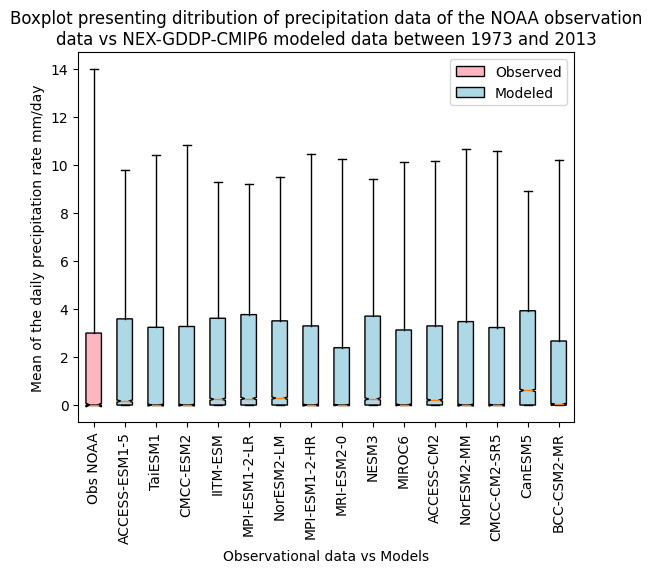

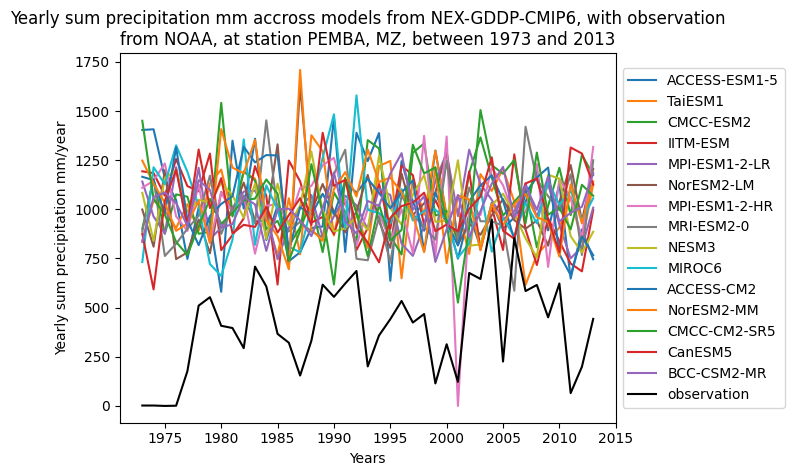

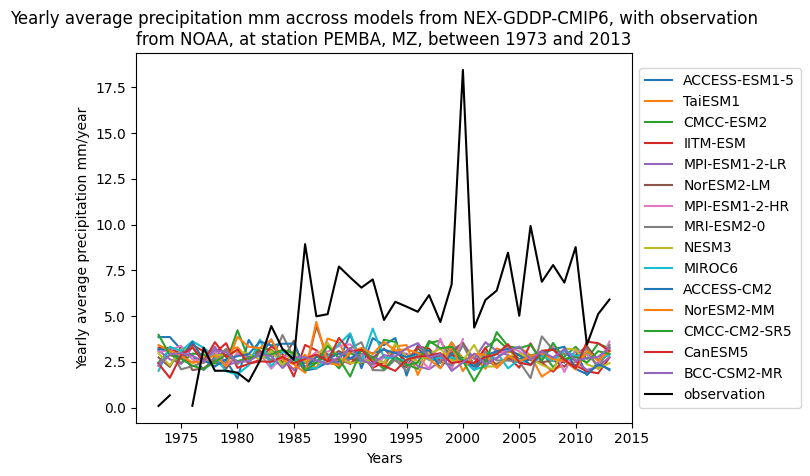

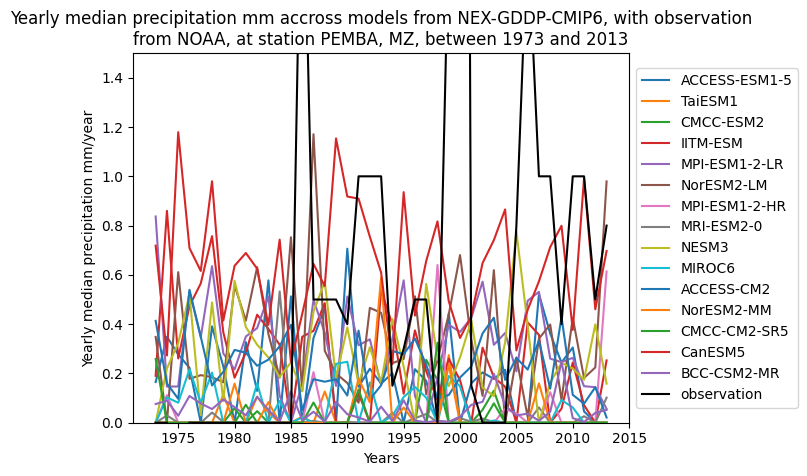

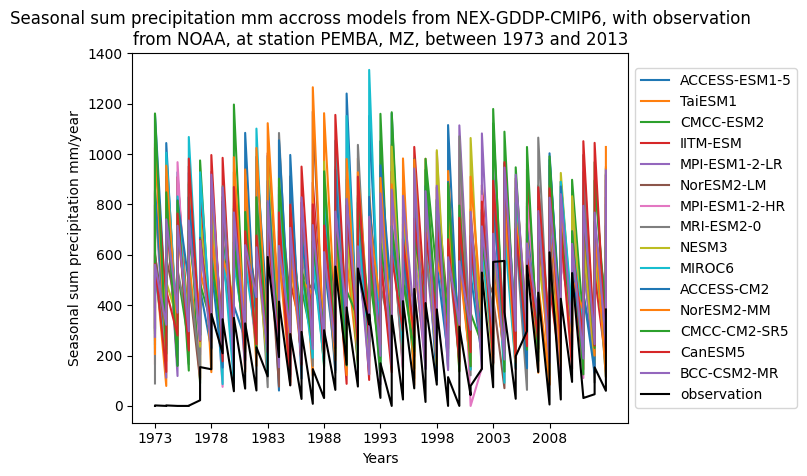

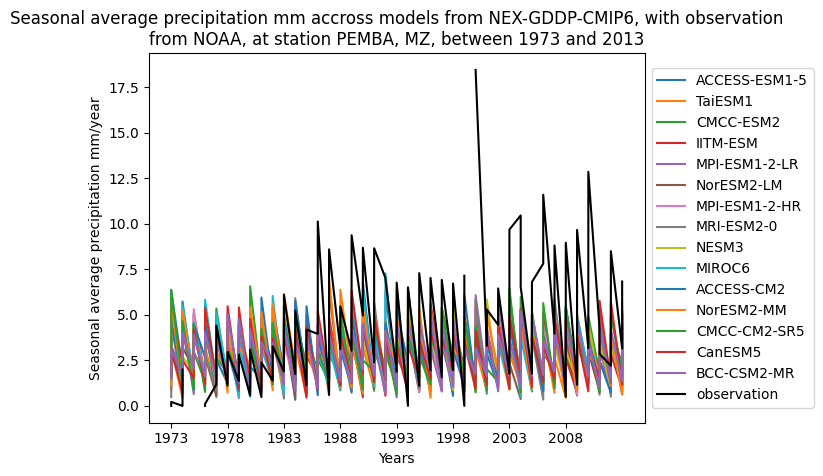

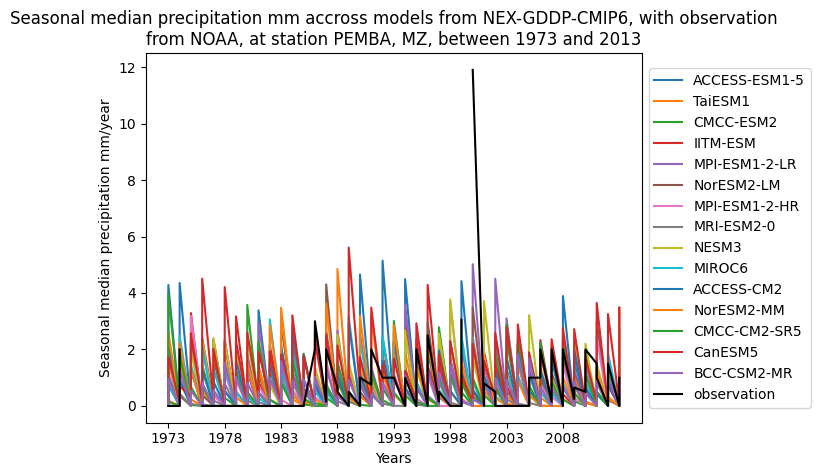

In [22]:
compare_(climate_var,data_obs_NOAA,'PEMBA, MZ')

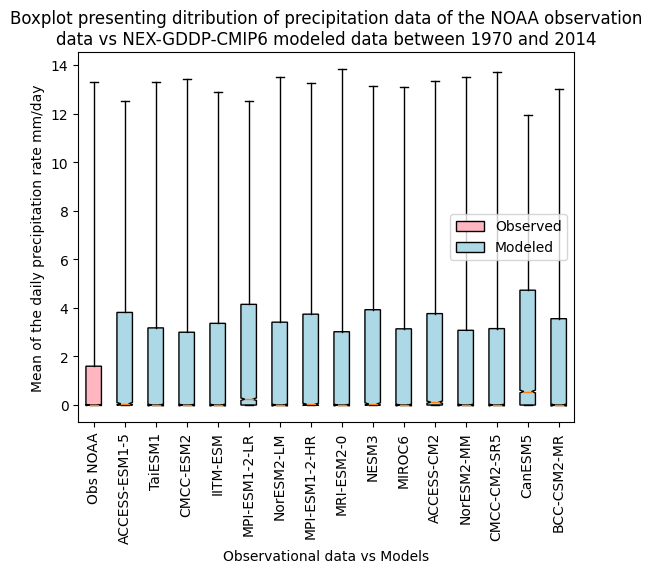

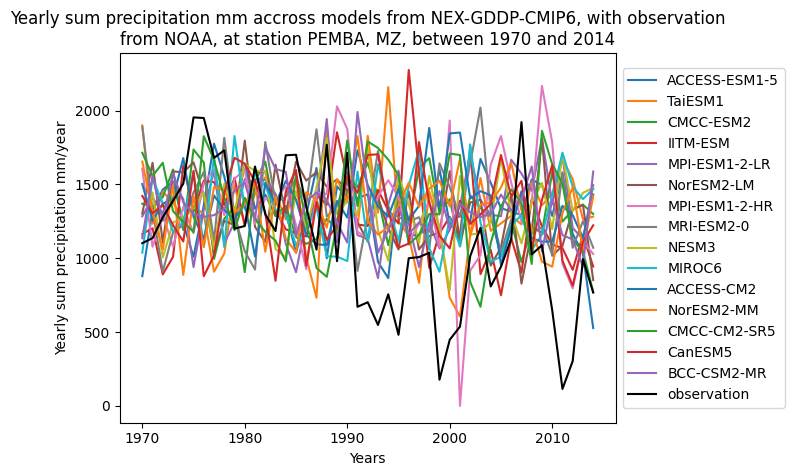

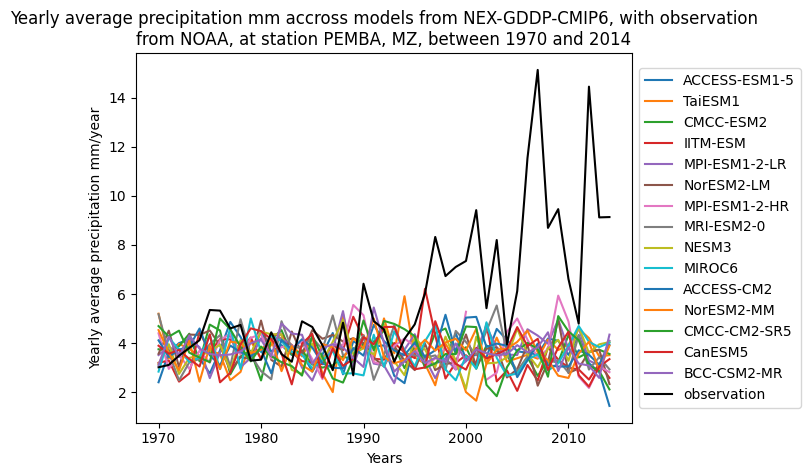

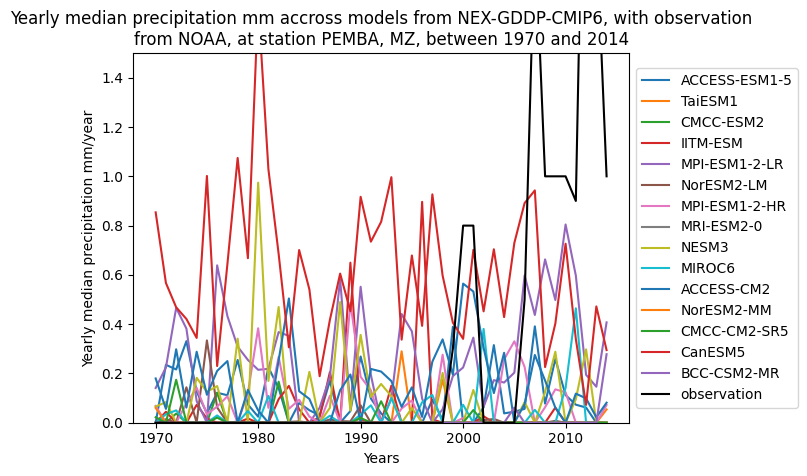

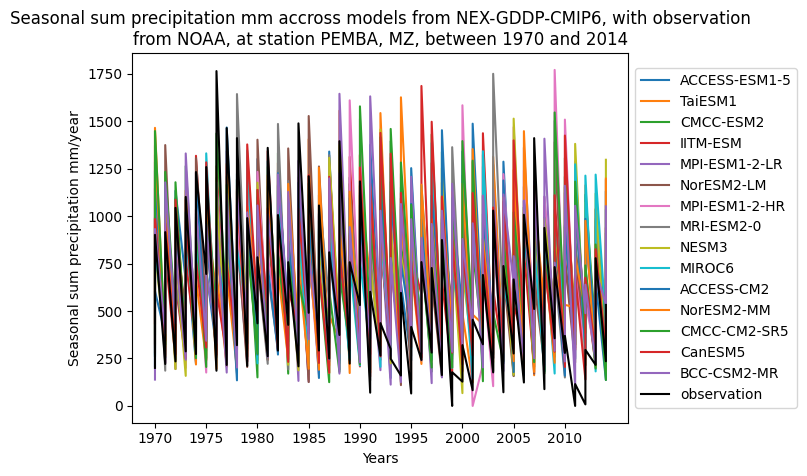

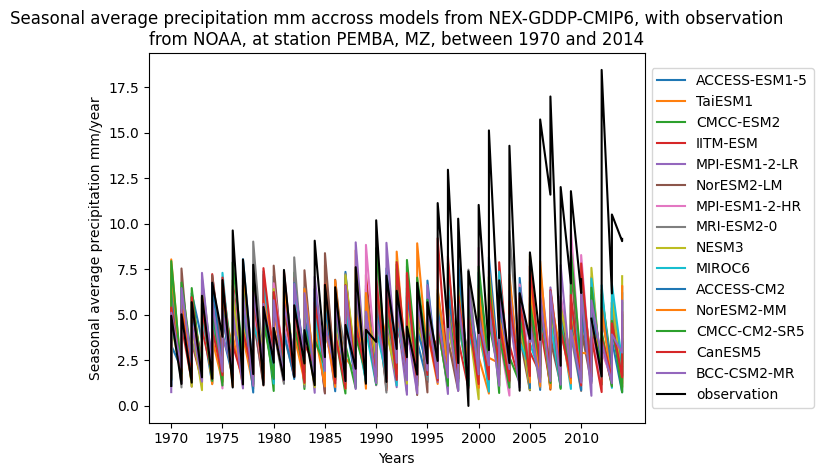

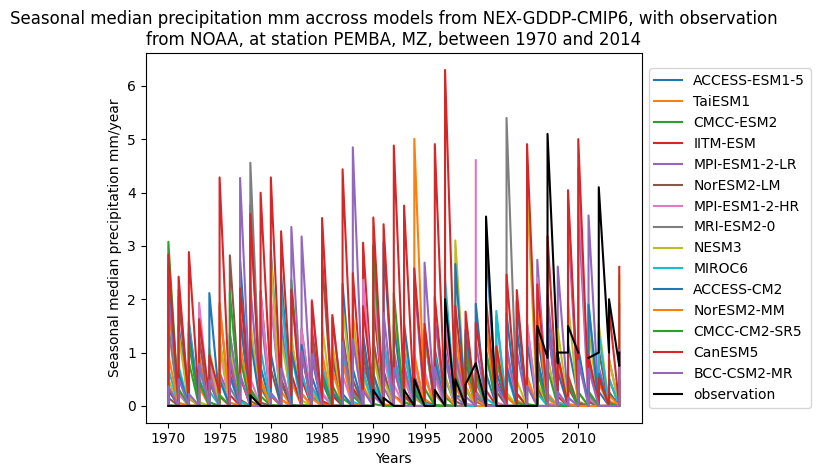

In [23]:
compare_(climate_var,data_obs_NOAA,'BEIRA, MZ')

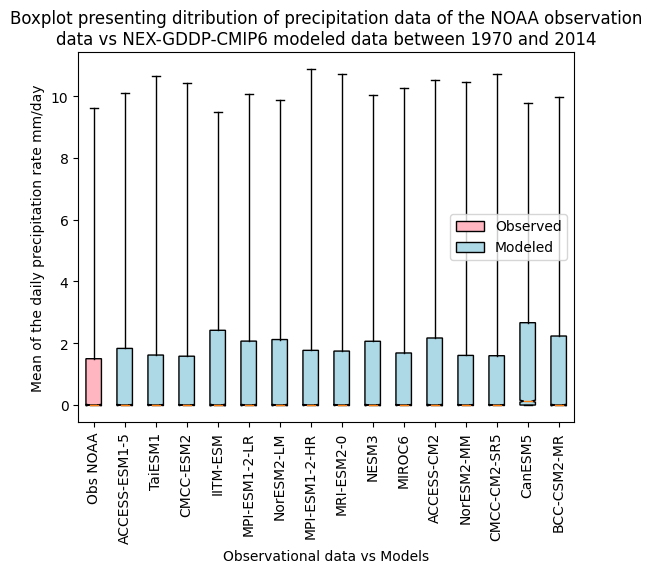

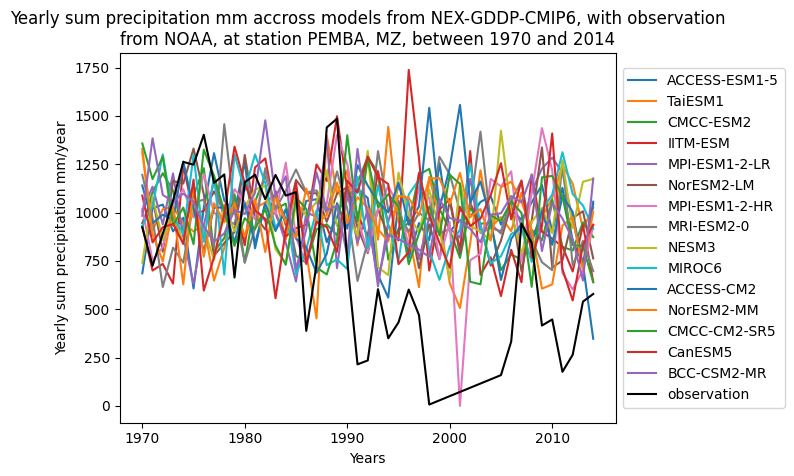

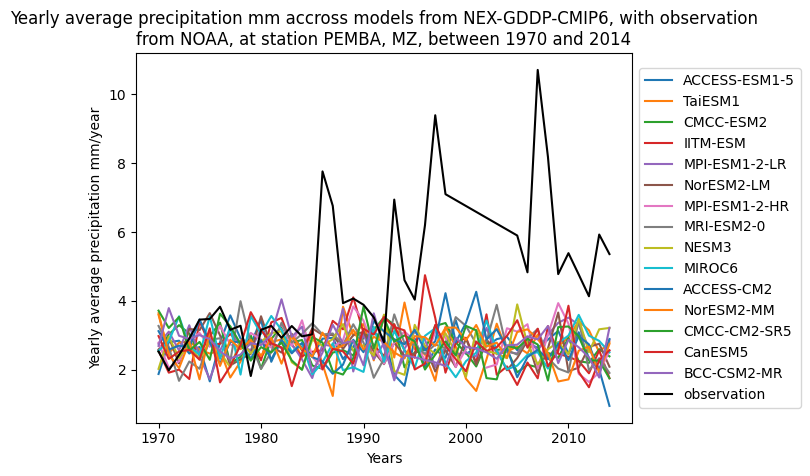

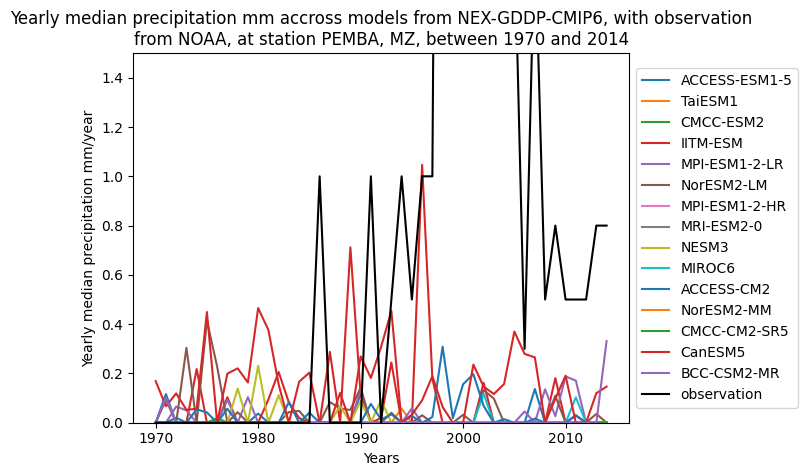

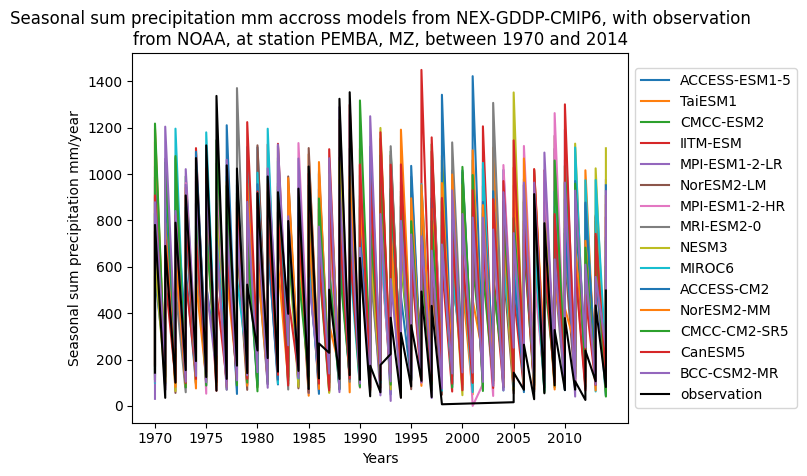

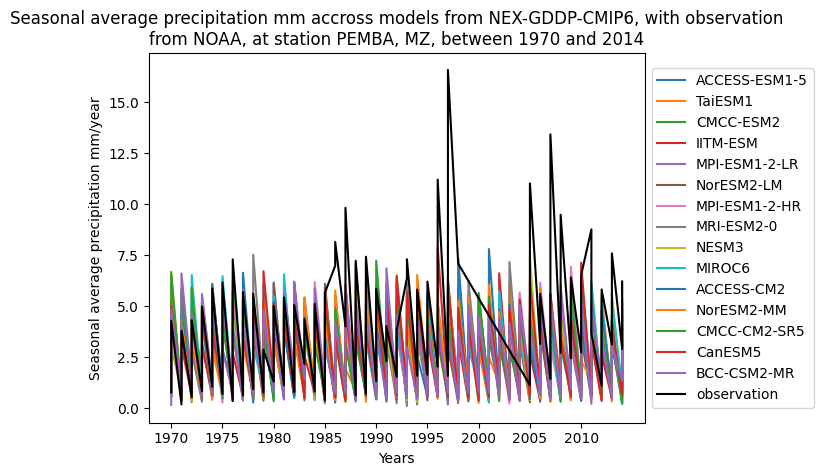

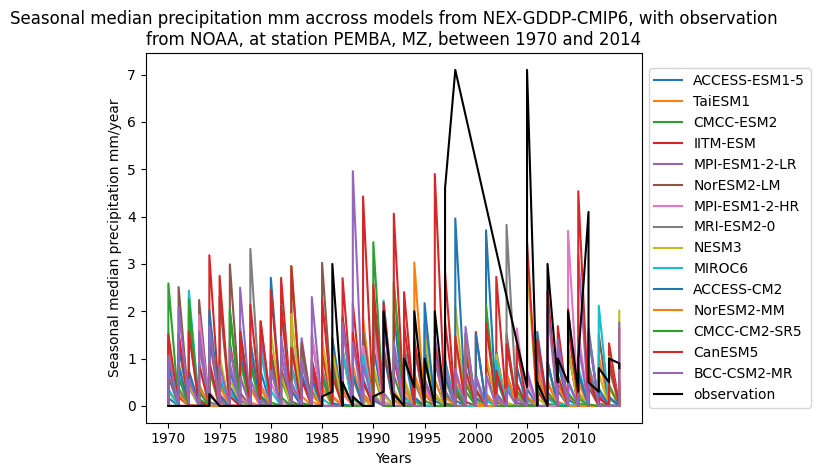

In [24]:
compare_(climate_var,data_obs_NOAA,'CHIMOIO, MZ')

## Compare temperature data for different stations

### Average temperature

In [45]:
df=compare_('tas',data_obs_NOAA,'PEMBA, MZ')
df.columns
#compare_('tas',data_obs_NOAA,'BEIRA, MZ')
#compare_('tas',data_obs_NOAA,'CHIMOIO, MZ')

Index(['Model', 'Date', 'Daily Maximum Near-Surface Air Temperature °C',
       'Year', 'Month', 'Season'],
      dtype='object')

In [46]:
df['Daily Maximum Near-Surface Air Temperature °C']

0         29.407166
1         29.242828
2         29.896942
3         30.779022
4         31.433685
            ...    
230099    34.402618
230100    34.845612
230101    34.729218
230102    33.846863
230103    31.960388
Name: Daily Maximum Near-Surface Air Temperature °C, Length: 230104, dtype: float64

In [48]:
compare_('tas',data_obs_NOAA,'PEMBA, MZ')

KeyError: 'Daily Near-Surface Air Temperature °C'

### Minimum temperature

In [ ]:
compare_('tasmin',data_obs_NOAA,'PEMBA, MZ')
compare_('tasmin',data_obs_NOAA,'BEIRA, MZ')
compare_('tasmin',data_obs_NOAA,'CHIMOIO, MZ')

### Maximum temperature

In [ ]:
compare_('tasmax',data_obs_NOAA,'PEMBA, MZ')
compare_('tasmax',data_obs_NOAA,'BEIRA, MZ')
compare_('tasmax',data_obs_NOAA,'CHIMOIO, MZ')

# Note concerning distribution of precipitation data
Observational data over this period much bigger than modeled data. However, mediane of all set of data close to 0 --> much more smaller values than big values

# BIAS CORRECTION - POINT WISE METHOD

[Scikit-downscale](https://github.com/pangeo-data/scikit-downscale/tree/main)
[Detailed process here](https://github.com/pangeo-data/scikit-downscale/blob/main/examples/2020ECAHM-scikit-downscale.ipynb)

In [ ]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")  # sklearn

import matplotlib.pyplot as plt
import seaborn as sns

import pandas as pd

#from utils import get_sample_data

sns.set(style='darkgrid')

In [ ]:
# prepare set of data for Bias correction
# load sample data

In [ ]:
# take out rows for which date is not in both set of data
(data_obs_NOAA, climate_var_NEX_GDDP_CMIP6_EmplacementStation,start_year,stop_year) = take_out_years_not_overlaping(data_obs_NOAA, climate_var_NEX_GDDP_CMIP6_EmplacementStation)

In [ ]:
data_obs_NOAA2=data_obs_NOAA.set_index('DATE')[['PRCP']]
type(data_obs_NOAA2.index[0])

In [ ]:
data_obs_NOAA2#[['PRCP']]['1974': '2014']

In [ ]:
# training
climate_var_NEX_GDDP_CMIP6_EmplacementStation_BC=climate_var_NEX_GDDP_CMIP6_EmplacementStation[climate_var_NEX_GDDP_CMIP6_EmplacementStation['Name station']==name_station].drop(['Name station','Year','Month','Season'],axis =1)
climate_var_NEX_GDDP_CMIP6_EmplacementStation_BC_model = climate_var_NEX_GDDP_CMIP6_EmplacementStation_BC[climate_var_NEX_GDDP_CMIP6_EmplacementStation_BC['Model'] =='ACCESS-CM2'].drop(['Model'],axis=1)
training = climate_var_NEX_GDDP_CMIP6_EmplacementStation_BC_model.rename(columns = {'Date':'time','Mean of the daily precipitation rate mm/day':'pcp'}).reset_index()

# changing format of Date for training
Date1 = training['time'].values
for i in np.arange(0,len(training)):
    training['time'][i] = Date1[i][6:10]+'-'+Date1[i][3:5]+'-'+Date1[i][0:2]#datetime.strptime(, '%Y-%M-%d').date()
    print(training['time'][i])
# .date() to avoid having the hours in the datetime
training=training.set_index('time').drop(['index'],axis=1)


# targets
targets = data_obs_NOAA[['NAME','DATE','PRCP']] # select only 3 columns of interest
targets = targets[targets['NAME']==name_station].rename(columns = {'DATE':'time','PRCP':'pcp'}).set_index('time').drop(['NAME'],axis=1) # the targets data is meant to represent our "observations"


# to have the same size of vectors
targets = targets.dropna() # drop rows with NaN
training = training[training.index.isin(list(targets.index))] # drop rows of training where date is equal to date where there is no value for target

In [ ]:
training

In [ ]:
targets[['pcp']]['1980': '2000']

In [ ]:
type(targets.index[0])

In [ ]:
Date1 = pr_obs_NOAA_to_compare_pemba['DATE'].values
pr_obs_NOAA_to_compare2_pemba = pr_obs_NOAA_to_compare_pemba.copy(deep=True)
for i in np.arange(0,len(pr_obs_NOAA_to_compare_pemba)):
    pr_obs_NOAA_to_compare2_pemba['DATE'][i] = datetime.strptime(Date1[i], '%Y-%M-%d').date() #Date1[0][8:10] +'-'+Date1[i][5:7]+'-'+Date1[i][0:4]
pr_obs_NOAA_to_compare2_pemba

In [ ]:
Date1 = data_NEX_GDDP_CMIP6_EmplacementStation_to_compare_pemba['Date'].values
data_NEX_GDDP_CMIP6_EmplacementStation_to_compare2_pemba = data_NEX_GDDP_CMIP6_EmplacementStation_to_compare_pemba.copy(deep=True).reset_index()
for i in np.arange(0,len(data_NEX_GDDP_CMIP6_EmplacementStation_to_compare2_pemba)):
    data_NEX_GDDP_CMIP6_EmplacementStation_to_compare2_pemba['Date'][i] = datetime.strptime(Date1[i][6:10]+'-'+Date1[i][3:5]+'-'+Date1[i][0:2], '%Y-%M-%d').date()
    #print(data_NEX_GDDP_CMIP6_EmplacementStation_to_compare2_pemba['Date'][i])
# .date() to avoid having the hours in the datetime
data_NEX_GDDP_CMIP6_EmplacementStation_to_compare2_pemba # 2h54

In [ ]:
# print a table of the training/targets data
display(pd.concat({'training': training, 'targets': targets}, axis=1))
#display(pd.DataFrame.merge(training,targets,on='time'))

# make a plot of the temperature and precipitation data
fig, axes = plt.subplots(ncols=1, nrows=2, figsize=(8, 6), sharex=True)
time_slice = slice('1990-01-01', '1990-12-31')

# plot-temperature
training[time_slice]['pcp'].plot(ax=axes[0], label='training')
targets[time_slice]['pcp'].plot(ax=axes[0], label='targets')
axes[0].legend()
axes[0].set_ylabel('Precipitation [mm/day]')

# plot-precipitation
training[time_slice]['pcp'].plot(ax=axes[1])
targets[time_slice]['pcp'].plot(ax=axes[1])
_ = axes[1].set_ylabel('Precipitation [mm/day]')

In [ ]:
# exploratory data analysis for arrm model

import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import QuantileTransformer
from sklearn.preprocessing import KBinsDiscretizer
from mlinsights.mlmodel import PiecewiseRegressor

def ARRM(n_bins=7):
    return Pipeline([
        ('')
    ])


sns.set(style='whitegrid')
c = {'train': 'black', 'predict': 'blue', 'test': 'grey'}

qqwargs = {'n_quantiles': int(1e6), 'copy': True, 'subsample': int(1e6)} # add int for n_quantiles and subsample to avoid
# foloowing problem:  InvalidParameterError: The 'n_quantiles' parameter of QuantileTransformer must be an int in the range [1, inf). Got 1000000.0 instead.
n_bins = 7

X = training[['pcp']]['1980': '2000'].values
y = targets[['pcp']]['1980': '2000'].values

X_train, X_test, y_train, y_test = train_test_split(X, y)
xqt = QuantileTransformer(**qqwargs).fit(X_train)

Xq_train = xqt.transform(X_train)
Xq_test = xqt.transform(X_test)

yqt = QuantileTransformer(**qqwargs).fit(y_train)
yq_train = xqt.transform(y_train)[:, 0]
yq_test = xqt.transform(y_test)[:, 0]


print(X.shape, y.shape, X_train.shape, X_test.shape, y_train.shape, y_test.shape)

# model = PiecewiseRegressor(binner=KBinsDiscretizer(n_bins=n_bins, strategy='quantile'))
# model.fit(Xq_train, yq_train)
# predq = model.predict(Xq_test)
# pred = qt.inverse_transform(predq.reshape(-1, 1))

y_train = y_train[:, 0]
for strat in ['kmeans', 'uniform', 'quantile']:
    model = PiecewiseRegressor(binner=KBinsDiscretizer(n_bins=n_bins, strategy=strat))

    model.fit(X_train, y_train)
    pred = model.predict(X_test)
    print(strat, model.score(X_test, y_test))
    
model = PiecewiseRegressor(binner=KBinsDiscretizer(n_bins=n_bins, strategy='kmeans'))
model.fit(X_train, y_train)
pred = model.predict(X_test)


fig, ax = plt.subplots(1, 1, figsize=(8, 8))
plt.scatter(X_train, y_train, c=c['train'], s=5, label='train')
plt.scatter(X_test, y_test, c=c['test'], s=5, label='test')
ax.legend()

fig, ax = plt.subplots(1, 1, figsize=(8, 8))
plt.scatter(np.sort(X_train, axis=0), np.sort(y_train, axis=0), c=c['train'], s=5, label='train')
plt.scatter(np.sort(X_test, axis=0), np.sort(y_test, axis=0), c=c['test'], s=5, label='test')
plt.plot(np.sort(X_test, axis=0), np.sort(pred, axis=0), c=c['predict'], lw=2, label='predictions')
ax.legend()

# fig, ax = plt.subplots(1, 1)
# ax.plot(Xq_test[:, 0], yq_test, ".", label='data', c=c['test'])
# ax.plot(Xq_test[:, 0], predq, ".", label="predictions", c=c['predict'])
# ax.set_title(f"Piecewise Linear Regression\n{n_bins} buckets")
# ax.legend()

fig, ax = plt.subplots(1, 1, figsize=(8, 8))
ax.plot(X_test[:, 0], y_test, ".", label='data', c=c['test'])
ax.plot(X_test[:, 0], pred, ".", label="predictions", c=c['predict'])
ax.set_title(f"Piecewise Linear Regression\n{n_bins} buckets")
ax.legend()

Scikit-downscale, the ability to test and compare arbitrary combinations of models under a common interface. This allows us to try many combinations of models and parameters, choosing only the best combinations. 

In [ ]:
import skdownscale
from skdownscale.pointwise_models import bcsd # name of the model to write 

# all modeled listed here
# C:\Users\CLMRX\AppData\Local\miniconda3\envs\geodata\Lib\site-packages\skdownscale\pointwise_models

In [ ]:
#parameters = {'detrend':True}

# parameters for QuantileMapper in bcsd
r'''
    Parameters
    ----------
    detrend : boolean, optional
        If True, detrend the data before quantile mapping and add the trend
        back after transforming. Default is False.
    lt_kwargs : dict, optional
        Dictionary of keyword arguments to pass to the LinearTrendTransformer
    qm_kwargs : dict, optional
        Dictionary of keyword arguments to pass to the QuantileMapper'''

model = bcsd.BcsdPrecipitation()#**parameters
model.fit(X_train, y) # problem, both vector do not have the same length. Problem comes from train_test_split(X, y), defined in _split.py,
# in C:\Users\CLMRX\AppData\Local\miniconda3\envs\geodata\Lib\site-packages\sklearn\model_selection 
# try to find _safe_indexing function, that generates return values. Say it is in utils but not found
predictions = model.predict(X_predict)

In [ ]:
len(y)-len(X_train)

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor

from skdownscale.pointwise_models import PureAnalog, AnalogRegression
from skdownscale.pointwise_models import BcsdTemperature, BcsdPrecipitation


models = {
    'GARD: PureAnalog-best-1': PureAnalog(kind='best_analog', n_analogs=1),
    'GARD: PureAnalog-sample-10': PureAnalog(kind='sample_analogs', n_analogs=10),
    'GARD: PureAnalog-weight-10': PureAnalog(kind='weight_analogs', n_analogs=10),
    'GARD: PureAnalog-weight-100': PureAnalog(kind='weight_analogs', n_analogs=100),
    'GARD: PureAnalog-mean-10': PureAnalog(kind='mean_analogs', n_analogs=10),
    'GARD: AnalogRegression-100': AnalogRegression(n_analogs=100),
    'GARD: LinearRegression': LinearRegression(),
    'BCSD: BcsdTemperature': BcsdTemperature(return_anoms=False),
    'Sklearn: RandomForestRegressor': RandomForestRegressor(random_state=0)
}

#train_slice = slice('1980-01-01', '1989-12-31')
#predict_slice = slice('1990-01-01', '1999-12-31')
train_slice = slice(datetime.date(1980, 1, 1), datetime.date(1989, 12, 31))
predict_slice = slice(datetime.date(1990, 1, 1), datetime.date(1999, 12, 31))

In [ ]:
# extract training / prediction data
X_train = training[['pcp']][train_slice]
y_train = targets[['pcp']][train_slice]
X_predict = training[['pcp']][predict_slice]

# Fit all models
for key, model in models.items():
    model.fit(X_train, y_train)